# Reproduction of DeepMicro: Deep Representation Learning for Disease Prediction based on Microbiome Data
#### Team Members
- Joaquin Ugarte (jugarte2@illinois.edu)
- Prasad Gole (gole2@illinois.edu)
- Ehit Agarwal (ehitda2@illinois.edu)

#### GitHub Repository
https://github.com/Prasad-py/DLH_Project

#### Project Video
https://drive.google.com/drive/folders/1sulQR6U7-jwWe9gUHLjr473GJ04IxXl8

# Introduction
The gut microbiome is a vital component of human health.$^1$ Recent evidence suggests that it can be used to predict various diseases.$^2$ 16S rRNA gene sequencing technology can be used to profile the most common components of the human microbiome in a cost-effective way.$^3$ Similarly, a deeper, strain level, resolution profile of the microbial community can be obtained by shotgun metagenomic sequencing technology.$^4$ As the cost of obtaining microbiome data decreases, there is a novel opportunity for machine learning techniques to be employed for the early prediction of diseases. Detecting diseases early will not only decrease healthcare costs but also improve patient outcomes.

Microbiome datasets often contain samples in the range of 10-1000, while the data itself can have hundreds of thousands of dimensions. This poses a challenge to train machine learning models directly on the highly sparse data. The large number of features are computationally expensive and the relatively low number of samples makes the model less generalizabile to other datasets. As of April 2024, state-of-the-art techniques in this field make use of Conditional Generative Adversarial Networks (C-GANs)$^5$ to artificially augment the size of the dataset and Variational Information Bottlenecks (VIBs)$^{6,7}$ to extract only the relevant features for disease prediction while filtering out redundant information.

At the time of publication of the DeepMicro study$^8$, there had been little work on deep learning applications for microbiome data with a rigorous evaluation scheme. DeepMicro transforms high-dimensional microbiome data into a robust low-dimensional representation using an autoencoder and then applies machine learning classification on the learned representation. A thorough validation scheme optimizes hyper-parameters using a grid search, where the test set is excluded during cross-validation to ensure fairness. DeepMicro outperforms the current best approaches based on the strain-level marker profile$^9$ in five datasets, including IBD (AUC=0.955), EW-T2D (AUC=0.899), C-T2D (AUC=0.763), Obesity (AUC=0.659) and Cirrhosis (AUC=0.940). For the Colorectal dataset, DeepMicro has slightly lower performance than the best approach (DeepMicro's AUC=0.803 vs. MetAML's AUC=0.811) Additionally, reducing the dimensionality has sped up model training and hyperparameter tuning buy 8-30 times.$^8$

# Scope of Reproducibility:
- Hypothesis 1: Training classifiers using a lower dimensional representation will result in more accurate predictions, as evaluated by area under the ROC.
- Hypothesis 2: Training classifiers using a lower dimensional representation will speed up the model training and hyperparameter tuning process.

The DeepMicro paper thoroughly describes their procedures. The datasets contain about 1000 samples in total and the datasets are all publically available on their GitHub repository$^{10}$. The models are implemented in a clear and straightforward manner. 
There is no mention of time required for training or evaluation in the paper, however the computations took about 12 hours on our slightly more powerful machine. For these reasons, the scope of replicating the paper and testing the hypotheses is expected to be high.

# Methodology

Encoded representations of all 12 datasets are obtained using the 4 autoencoders: Shallow AutoEncoder(SAE), Deep AutoEncoder(DAE), Variational AutoEncoder(VAE), Convolutional AutoEncoder(CAE). Each autoencoder model is evaluated by MSE loss on the test set. The best model for each dataset and autoencoder combination is trained on the 3 classifiers: Multi-layer Perceptron(MLP), Support Vector Machine(SVM), Random Forest(RF). The original dataset and its encoded representation are used to train separate a classifier models. The classifier models are evaluated by Area Under the ROC Curve (AUC) using 5-fold cross-validation. All train/validation/test splits are stratified to keep the datasets balanced. The best performing model, is selected for each combination.

## Environment

Our project uses Python version 3.10.7. A requirements.txt file in the GitHub repository of our project lists the version of all the required libraries.

In [1]:
import random
import math
import copy
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
import torch.cuda
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


##  Data

Publicly available human gut metagenomic samples from six disease cohorts (inflammatory bowel disease, type 2 diabetes, obesity, liver cirrhosis, and colorectal cancer) are obtained from the MetAML study. Data can downloaded from the DeepMicro GitHub repository.$^{10}$ Train/test split is chosen to be 80/20. The abundance and marker datasets are preprocessed accordingly and the features and label are extracted. The data is converted into an image format for the CAE.

In [3]:
# Configure parameters
DATASET = 8
ALL_HPS = False
RANDOM_SEED = 0
TEST_SIZE = 0.2
NUM_FOLDS = 5
BATCH_SIZE = 128

In [4]:
# Set random seeds
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# A dict to select a dataset
datasets = {
    0: 'abundance_Cirrhosis.txt',
    1: 'abundance_Colorectal.txt',
    2: 'abundance_IBD.txt',
    3: 'abundance_Obesity.txt',
    4: 'abundance_T2D.txt',
    5: 'abundance_WT2D.txt',
    6: 'marker_Cirrhosis.txt',
    7: 'marker_Colorectal.txt',
    8: 'marker_IBD.txt',
    9: 'marker_Obesity.txt',
    10: 'marker_T2D.txt',
    11: 'marker_WT2D.txt'
}
dataset_file = 'data/' + datasets[DATASET]

In [5]:
# Load the dataset into a dataframe
def load_raw_data(dataset_file):
    with open(dataset_file, 'r') as fo:
        df = pd.read_csv(fo, sep='\t', header=None, index_col=0, low_memory=False)
        return df

raw_data = load_raw_data(dataset_file)

# Preprocessing for abundance and marker datasets
feature_string = ''
file_name = dataset_file.split('/')[-1].split('.')[0]
if file_name.split('_')[0] == 'abundance':
    feature_string = 'k__'
elif file_name.split('_')[0] == 'marker':
    feature_string = 'gi|'

# Compute descriptive statistics
def calculate_stats(raw_data):
    if file_name.split('_')[1] == 'Obesity':
        negative_samples = raw_data.loc['disease'].value_counts()['leaness']
    else:
        negative_samples = raw_data.loc['disease'].value_counts()['n']
    positive_samples = raw_data.shape[1] - negative_samples

    print(file_name)
    print(f'\tTotal Samples: {raw_data.shape[1]}')
    print(f'\tPositive Samples: {positive_samples}')
    print(f'\tHealthy Controls: {negative_samples}')
    print(f'\tFraction of Positive Samples: {round(positive_samples/raw_data.shape[1], 3)}')
    print(f'\tNumber of Features: {raw_data.index.str.contains(feature_string, regex=False).size}')

calculate_stats(raw_data)

# Extract features and labels into tensors
def process_data(raw_data):
    label_dict = {
        # Controls
        'n': 0,
        # Cirrhosis
        'cirrhosis': 1,
        # Colorectal Cancer
        'cancer': 1, 'small_adenoma': 0,
        # IBD
        'ibd_ulcerative_colitis': 1, 'ibd_crohn_disease': 1,
        # T2D and WT2D
        't2d': 1,
        # Obesity
        'leaness': 0, 'obesity': 1,
    }

    X = raw_data.loc[raw_data.index.str.contains(feature_string, regex=False)].T
    y = raw_data.loc['disease']
    y = y.replace(label_dict)

    X_train, X_test, y_train, y_test = train_test_split(X.values.astype('float64'), y.values.astype('int'), test_size=TEST_SIZE, stratify=y.values)
    
    # Process data for CAE
    input_dim = math.ceil(math.sqrt(X_train.shape[1]))
    cae_X_train = np.concatenate([X_train, np.zeros((X_train.shape[0], input_dim**2 - X_train.shape[1]))], axis=1).reshape((X_train.shape[0], 1, input_dim, input_dim))
    cae_X_test = np.concatenate([X_test, np.zeros((X_test.shape[0], input_dim**2 - X_test.shape[1]))], axis=1).reshape((X_test.shape[0], 1, input_dim, input_dim))

    return X_train, X_test, cae_X_train, cae_X_test, y_train, y_test

processed_data = process_data(raw_data)

marker_IBD
	Total Samples: 110
	Positive Samples: 25
	Healthy Controls: 85
	Fraction of Positive Samples: 0.227
	Number of Features: 91967


C:\Users\Ehit\AppData\Local\Temp\ipykernel_15780\2460705878.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(label_dict)


##   Model

### Helper Functions

Early stopping with checkpoint saving is used to ensure that the models train in a reasonable time and do not overfit.
The weights of all the neural network layers are initialised using the Glorot Uniform initialiser.

In [6]:
class EarlyStopping:    
    def __init__(self, patience, rho):
        self.patience = patience
        self.rho = rho
        self.counter = 0
        self.min_val_loss = np.Inf
        self.checkpoint = None

    def __call__(self, val_loss, model):
        if val_loss >= self.rho*self.min_val_loss:
            self.counter += 1
            if self.counter == self.patience:
                return True
        else:
            self.checkpoint = copy.deepcopy(model.state_dict())
            self.min_val_loss = val_loss
            self.counter = 0
        return False

# Initialize neural network parameters
def init_weights(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        nn.init.xavier_uniform_(layer.weight)

### AutoEncoders

The 4 autoencoders can have the following hyperparameters.

Shallow AutoEncoder:
- hidden_dim: Dimension of the hidden layer (32, 64, 128, 256, 512).

Deep AutoEncoder:
- hidden_dim: Dimension of the hidden layer (32, 64, 128, 256, 512).
- degree: Number of hidden layers in the encoder/decoder after the first hidden layer (1, 2). Degree of 0 is an SAE.

Variational AutoEncoder:
- hidden_dim: Dimension of the hidden layer (32, 64, 128, 256, 512).
- latent_dim: Dimension of the distribution parameters (4, 8, 16).

Convolutional AutoEncoder:
- num_filters: Number of filters in the first layer (4, 8, 16, 32, 64).
- num_layers: Number of layers in the encoder/decoder (2, 3).

Successive layers in the encoder have half the dimension of their previous layer. The encoder and decoder networks are symmetric. ReLU is the activation function for all layers. MSE is the loss function and Adam is used as the optimizer.

In [7]:
# Deep AutoEncoder
class DAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, degree=0):
        super().__init__()

        self.encoder = nn.Sequential()

        # First layer
        self.encoder.append(nn.Linear(input_dim, hidden_dim*2**degree))
        if degree > 0:
            self.encoder.append(nn.BatchNorm1d(hidden_dim*2**degree))
        self.encoder.append(nn.ReLU(inplace=True))

        # Iteratively add layers to the encoder
        for i in range(degree, 0, -1):
            self.encoder.append(nn.Linear(hidden_dim*2**i, hidden_dim*2**(i - 1)))
            if i > 1:
                self.encoder.append(nn.BatchNorm1d(hidden_dim*2**(i - 1)))
            self.encoder.append(nn.ReLU(inplace=True))

        # Iteratively add layers to the decoder
        self.decoder = nn.Sequential()
        for i in range(degree):
            self.decoder.append(nn.Linear(hidden_dim*2**i, hidden_dim*2**(i + 1)))
            self.decoder.append(nn.BatchNorm1d(hidden_dim*2**(i + 1)))
            self.decoder.append(nn.ReLU(inplace=True))

        # Last layer
        self.decoder.append(nn.Linear(hidden_dim*2**degree, input_dim))
        self.decoder.append(nn.ReLU(inplace=True))

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def fit(self, train_loader, val_loader, epochs, patience, rho):
        # Initialize weights, loss function and optimizer
        self.apply(init_weights)
        loss_func = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)

        # Train the DAE
        losses = []
        es = EarlyStopping(patience, rho)
        for epoch in range(epochs):
            self.train()
            loss = 0
            for X, y in train_loader:
                optimizer.zero_grad()
                X_hat = self(X)
                batch_loss = loss_func(X, X_hat)
                batch_loss.backward()
                optimizer.step()
                loss += batch_loss.item()
            losses.append(loss)
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for X, y in val_loader:
                    X_hat = self(X)
                    val_loss += loss_func(X, X_hat)

            if epoch%10 == 0:
                print(f'Epoch {epoch} Loss: {loss:.4}, Val Loss: {val_loss:.4}')

            # Early Stopping
            if es(val_loss.item(), self):
                break

        # Load best model from the checkpoint
        self.load_state_dict(es.checkpoint)

        return es.min_val_loss, losses

In [8]:
# Variational AutoEncoder
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, latent_dim=4):
        super().__init__()

        # Standard normal distribution to obtain samples
        self.N = torch.distributions.normal.Normal(0, 1)

        # Encoder intermediate layer
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True)
        )

        # Encoder latent layer
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder layer
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Obtain latent distribution parameters
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)

        # Reparameterize the standard normal samples
        z = mu + log_var.exp()*self.N.rsample(mu.shape)

        # Compute KL divergence
        kld = -0.5*(1 + log_var - mu**2 - log_var.exp()).sum()

        return self.decoder(z), kld

    def fit(self, train_loader, val_loader, epochs, patience, rho):
        # Initialize weights, loss function and optimizer
        self.apply(init_weights)
        loss_func = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-5)

        # Train the VAE
        losses = []
        es = EarlyStopping(patience, rho)
        for epoch in range(epochs):
            self.train()
            loss = 0
            for X, y in train_loader:
                optimizer.zero_grad()
                X_hat, kld_loss = self(X)
                batch_loss = loss_func(X, X_hat) + kld_loss
                batch_loss.backward()
                optimizer.step()
                loss += batch_loss.item()
            losses.append(loss)
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for X, y in val_loader:
                    X_hat, kld_loss = self(X)
                    val_loss += loss_func(X, X_hat) + kld_loss

            if epoch%10 == 0:
                print(f'Epoch {epoch} Loss: {loss:.4}, Val Loss: {val_loss:.4}')

            # Early Stopping
            if es(val_loss.item(), self):
                break

        # Load best model from the checkpoint
        self.load_state_dict(es.checkpoint)

        return es.min_val_loss, losses

In [9]:
# Convolutional AutoEncoder
class CAE(nn.Module):
    def __init__(self, input_dim, num_filters=4, num_layers=2):
        super().__init__()

        # Initialize containers to store hyperparameters of encoder layers
        input_dims = []
        kernel_sizes = []
        strides = []
        self.encoder = nn.Sequential()

        # First encoder layer
        input_dims.append(input_dim)
        kernel_sizes.append(max(1, input_dims[-1]//10))
        strides.append(max(1, kernel_sizes[-1]//4))
        num_filters = [num_filters]
        self.encoder.append(nn.Conv2d(in_channels=1, out_channels=num_filters[-1], kernel_size=kernel_sizes[-1], stride=strides[-1]))
        self.encoder.append(nn.BatchNorm2d(num_filters[-1]))
        self.encoder.append(nn.ReLU(inplace=True))

        # Successive encoder layers
        for i in range(1, num_layers):
            input_dims.append((input_dims[-1] - kernel_sizes[-1])//strides[-1] + 1)
            kernel_sizes.append(max(1, input_dims[-1]//10))
            strides.append(max(1, kernel_sizes[-1]//2))
            self.encoder.append(nn.Conv2d(in_channels=num_filters[-1], out_channels=max(1, num_filters[-1]//2), kernel_size=kernel_sizes[-1], stride=strides[-1]))
            if i < num_layers - 1:
                self.encoder.append(nn.BatchNorm2d(max(1, num_filters[-1]//2)))
            self.encoder.append(nn.ReLU(inplace=True))
            num_filters.append(max(1, num_filters[-1]//2))

        # Flatten the encoded embedding
        self.encoder.append(nn.Flatten(start_dim=1))

        # Compute encoded dimension
        hidden_dim = (input_dims[-1] - kernel_sizes[-1])//strides[-1] + 1
        self.encoded_dim = num_filters[-1]*hidden_dim**2

        # First decoder layer
        self.decoder = nn.Sequential()
        self.decoder.append(nn.Unflatten(dim=1, unflattened_size=(num_filters[-1], hidden_dim, hidden_dim)))

        # Successive decoder layers
        output_padding = input_dims[-1] - (hidden_dim - 1)*strides[-1] - kernel_sizes[-1]
        for i in range(num_layers - 1, 0, -1):
            self.decoder.append(nn.ConvTranspose2d(in_channels=num_filters[i], out_channels=num_filters[i - 1], kernel_size=kernel_sizes[i], stride=strides[i], output_padding=output_padding))
            self.decoder.append(nn.BatchNorm2d(num_filters[i - 1]))
            self.decoder.append(nn.ReLU(inplace=True))
            output_padding = input_dims[i - 1] - (input_dims[i] - 1)*strides[i - 1] - kernel_sizes[i - 1]

        # Last decoder layer
        self.decoder.append(nn.ConvTranspose2d(in_channels=num_filters[0], out_channels=1, kernel_size=kernel_sizes[0], stride=strides[0], output_padding=output_padding))
        self.decoder.append(nn.ReLU(inplace=True))

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def fit(self, train_loader, val_loader, epochs, patience, rho):
        # Initialize weights, loss function and optimizer
        self.apply(init_weights)
        loss_func = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-3)

        # Train the CAE
        losses = []
        es = EarlyStopping(patience, rho)
        for epoch in range(epochs):
            self.train()
            loss = 0
            for X, y in train_loader:
                optimizer.zero_grad()
                X_hat = self(X.to(device))
                batch_loss = loss_func(X, X_hat)
                batch_loss.backward()
                optimizer.step()
                loss += batch_loss.item()
            losses.append(loss)
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for X, y in val_loader:
                    X_hat = self(X)
                    val_loss += loss_func(X, X_hat)

            if epoch%10 == 0:
                print(f'Epoch {epoch} Loss: {loss:.4}, Val Loss: {val_loss:.4}')

            # Early Stopping
            if es(val_loss.item(), self):
                break

        # Load best model from the checkpoint
        self.load_state_dict(es.checkpoint)

        return es.min_val_loss, losses

### Classifiers

The 3 classifiers have the following hyperparameters.

Multi-Layer Perceptron
- hidden_dim: Dimension of the first hidden layer (10, 30, 50, 100).
- num_layers: Number of hidden layers (1, 2, 3)
- dropout: Ratio of units selected for dropout (0.1, 0.3).
- epochs: Maximum number of epochs to train (30, 50, 100, 200, 300).

A successive layer in the MLP will have half the dimension of its previous layer. The activation function for the hidden layers is ReLU, while Sigmoid is used for the output layer. BCE is the loss function and Adam is the optimizer.

Support Vector Machine
- C: Regularization parameter for squared l2 penalty (2^-5, 2^-3, 2^-1, 2, 2^3, 2^5).
- gamma: Kernel coefficient for rbf (2^-15, 2^-13, 2^-11, 2^-9, 2^-7, 2^-5, 2^-3, 2^-1, 2, 2^3).

The SVM uses a radial basis function (RBF) kernel. The SVM model in this framework is designed to handle binary classification problems and is capable of outputting probabilities for AUC calculation using Platt scaling.

Random Forest
- n_estimators: Number of trees in the forest (100, 300, 500, 700, 900).
- criterion: Function to measure the quality of a split('gini', 'log_loss').
- min_samples_leaf: Minimum number of samples required to be at a leaf node (1, 5).
- max_features: Function applied to total features to find the number of features to consider when looking for the best split ('sqrt', 'log2').

In [10]:
# Multi-Layer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=10, num_layers=1, dropout=0.1, epochs=30):
        super().__init__()
        
        self.epochs=epochs
        self.net = nn.Sequential()

        # Input layer
        self.net.append(nn.Linear(input_dim, hidden_dim))
        self.net.append(nn.BatchNorm1d(hidden_dim))
        self.net.append(nn.ReLU(inplace=True))
        self.net.append(nn.Dropout(dropout))

        # Iteratively add hidden layers
        for i in range(num_layers - 1):
            self.net.append(nn.Linear(hidden_dim, max(1, hidden_dim//2)))
            self.net.append(nn.BatchNorm1d(max(1, hidden_dim//2)))
            self.net.append(nn.ReLU(inplace=True))
            self.net.append(nn.Dropout(dropout))
            hidden_dim = max(1, hidden_dim//2)

        # Output layer
        self.net.append(nn.Linear(hidden_dim, 1))
        self.net.append(nn.Sigmoid())

    def forward(self, x):
        return self.net(x)
    
    def fit(self, X_train, X_val, y_train, y_val, patience, rho):
        # Initialize weights, loss function and optimizer
        self.apply(init_weights)
        loss_func = nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

        # Train the classifier
        losses = []
        es = EarlyStopping(patience, rho)
        for epoch in range(self.epochs):
            self.train()
            optimizer.zero_grad()
            y_hat = self(X_train).squeeze(dim=-1)
            loss = loss_func(y_hat, y_train)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            self.eval()
            with torch.no_grad():
                y_hat = self(X_val).squeeze(dim=-1)
                val_loss = loss_func(y_hat, y_val)

            if epoch%10 == 0:
                print(f'Epoch {epoch} Loss: {loss:.4}, Val Loss: {val_loss:.4}')

            # Early Stopping
            if es(val_loss.item(), self):
                break

        # Load best model from the checkpoint
        self.load_state_dict(es.checkpoint)

        return es.min_val_loss, losses

### DeepMicro Framework

The AutoEncoder and Classifier classes are used for initialising the autoencoder and classifier models, respectively. The DeepMicro class trains the autoencoder models, and then trains the classifers using the best autoencoder model.

In [11]:
class AutoEncoder():
    def __init__(self, train_loader, val_loader, test_loader, ae_type, ae_args):
        # Initialise attributes
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        
        # Initialise models
        X_sample, _ = next(iter(self.train_loader))
        if ae_type == 'sae' or ae_type == 'dae':
            hidden_dim, degree = ae_args
            self.model = DAE(input_dim=X_sample.shape[1], hidden_dim=hidden_dim, degree=degree)
            self.encoded_dim = hidden_dim
            hps = '_' + str(hidden_dim) + '_' + str(degree)
        elif ae_type == 'vae':
            hidden_dim, latent_dim = ae_args
            self.model = VAE(input_dim=X_sample.shape[1], hidden_dim=hidden_dim, latent_dim=latent_dim)
            self.encoded_dim = hidden_dim
            hps = '_' + str(hidden_dim) + '_' + str(latent_dim)
        elif ae_type == 'cae':
            num_filters, num_layers = ae_args
            self.model = CAE(input_dim=X_sample.shape[2], num_filters=num_filters, num_layers=num_layers)
            self.encoded_dim = self.model.encoded_dim
            hps = '_' + str(num_filters) + '_' + str(num_layers)
        self.path = 'results/' + file_name + '_' + ae_type + hps + '.pt'

    def train(self, epochs=101, patience=10, rho=0.99):
        return self.model.fit(self.train_loader, self.val_loader, epochs, patience, rho)
    
    def save_model(self, path=None):
        if not path:
            path = self.path
        torch.save(self.model.state_dict(), path)
    
    def load_model(self, path=None):
        if not path:
            path = self.path
        self.model.load_state_dict(torch.load(path))
        self.model.eval()
    
    def evaluate(self):
        self.model.eval()
        with torch.no_grad():
            loss_func = nn.MSELoss()
            loss = 0
            for X, _ in self.test_loader:
                X_hat = self.model(X)
                if isinstance(X_hat, tuple):
                    X_hat = X_hat[0]
                batch_loss = loss_func(X, X_hat)
                loss += batch_loss.item()
        return loss

In [12]:
class Classifier():
    def __init__(self, clf_data, clf_type, clf_args):
        # Initialise attributes and models
        self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = clf_data
        hidden_dim, num_layers, dropout, epochs = clf_args
        self.model = MLP(input_dim=self.X_train.shape[1], hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, epochs=epochs)

    def train(self, patience=10, rho=0.99):
        return self.model.fit(self.X_train, self.X_val, self.y_train, self.y_val, patience, rho)
    
    def evaluate(self):
        self.model.eval()
        with torch.no_grad():
            loss_func = nn.BCELoss()
            y_hat = self.model(self.X_test).squeeze(-1)
            loss = loss_func(y_hat, self.y_test)
            y_pred = y_hat.round().detach()
        y_true = self.y_test.detach()
        y_score = y_hat.detach()
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_score)
        return (loss.item(), acc, auc)

In [13]:
class DeepMicro():
    def __init__(self, processed_data, num_folds, batch_size):
        # Split the data into K folds
        self.X_train, self.X_test, self.cae_X_train, self.cae_X_test, self.y_train, self.y_test = processed_data
        self.num_folds = num_folds
        self.train_val_loaders = []
        self.skf_indices = []
        skf = StratifiedKFold(self.num_folds)
        for k, (train_idx, val_idx) in enumerate(skf.split(self.X_train, self.y_train)):
            self.skf_indices.append((train_idx, val_idx))
            train_loader = DataLoader(TensorDataset(torch.Tensor(self.X_train[train_idx]), torch.Tensor(self.y_train[train_idx])), batch_size=batch_size)
            val_loader = DataLoader(TensorDataset(torch.Tensor(self.X_train[val_idx]), torch.Tensor(self.y_train[val_idx])), batch_size=batch_size)
            cae_train_loader = DataLoader(TensorDataset(torch.Tensor(self.cae_X_train[train_idx]), torch.Tensor(self.y_train[train_idx])), batch_size=batch_size)
            cae_val_loader = DataLoader(TensorDataset(torch.Tensor(self.cae_X_train[val_idx]), torch.Tensor(self.y_train[val_idx])), batch_size=batch_size)
            self.train_val_loaders.append([train_loader, val_loader, cae_train_loader, cae_val_loader])
        self.test_loaders = [
            DataLoader(TensorDataset(torch.Tensor(self.X_test), torch.Tensor(self.y_test)), batch_size=batch_size),
            DataLoader(TensorDataset(torch.Tensor(self.cae_X_test), torch.Tensor(self.y_test)), batch_size=batch_size)
        ]

    def train_aes(self):
        with open('en_dict', 'rb') as fo:
            en_dict = pickle.load(fo)
        
        # Train the AutoEncoders
        for ae_type in AES:
            print(f'Training {ae_type.upper()}')
            
            plt.style.use('fivethirtyeight')
            plt.title(f'{ae_type.upper()} Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            
            # Iterate over hyperparameter combinations
            for ae_args in get_hp_tuples(HYP_PARAMS[ae_type]):
                print(f'\t{ae_args}')
                ae = AutoEncoder(train_loader=self.train_val_loaders[0][0 + 2*(ae_type == 'cae')], val_loader=self.train_val_loaders[0][1 + 2*(ae_type == 'cae')], test_loader=self.test_loaders[1*(ae_type == 'cae')], ae_type=ae_type, ae_args=ae_args)
                en_loss = ae.train()
                en_eval = ae.evaluate()
                en_dict[(file_name, ae_type, ae_args)] = [en_eval, en_loss]
                ae.save_model()

                plt.plot(en_loss[1], label=str(ae_args[0]) + '_' + str(ae_args[1]))
            plt.yscale('log')
            plt.legend()
            plt.tight_layout()
            plt.savefig('results/' + ae_type + '.png')
            plt.show()

        with open('en_dict', 'wb') as fo:
            pickle.dump(en_dict, fo)
    
    # Find the best model for each AutoEncoder
    def get_best_aes(self):
        with open('en_dict', 'rb') as fo:
            en_dict = pickle.load(fo)

        for key, value in en_dict.items():
            print(f'{key}: {value[0]:.4}')

        self.min_en_loss = {
            'sae': [np.Inf, ()],
            'dae': [np.Inf, ()],
            'vae': [np.Inf, ()],
            'cae': [np.Inf, ()]
        }

        for key in en_dict.keys():
            if key[0] == file_name:
                if en_dict[key][0] < self.min_en_loss[key[1]][0]:
                    self.min_en_loss[key[1]][0] = en_dict[key][0]
                    self.min_en_loss[key[1]][1] = key[2]

        print(self.min_en_loss)

    def train_clfs(self, min_en_loss=None, batch_size=BATCH_SIZE):
        with open('clf_dict', 'rb') as fo:
            clf_dict = pickle.load(fo)

        if not min_en_loss:
            min_en_loss = self.min_en_loss

        # Encode the data in all the folds
        print('Encoding Folds')
        en_data = {}
        for ae_type, ae_args in min_en_loss.items():
            if ae_args[1]:
                print(f'\t{ae_type}')
                ae = AutoEncoder(train_loader=self.train_val_loaders[0][0 + 2*(ae_type == 'cae')], val_loader=None, test_loader=None, ae_type=ae_type, ae_args=ae_args[1])
                ae.load_model('results/' + file_name + '_' + ae_type + '_' + str(ae_args[1][0]) + '_' + str(ae_args[1][1]) + '.pt')

                en_data[ae_type] = []
                for k in range(self.num_folds):
                    if ae_type == 'cae':
                        en_data[ae_type].append([
                            ae.model.encoder(torch.Tensor(self.cae_X_train[self.skf_indices[k][0]])).detach(),
                            ae.model.encoder(torch.Tensor(self.cae_X_train[self.skf_indices[k][1]])).detach(),
                        ])
                    else:
                        en_data[ae_type].append([
                            ae.model.encoder(torch.Tensor(self.X_train[self.skf_indices[k][0]])).detach(),
                            ae.model.encoder(torch.Tensor(self.X_train[self.skf_indices[k][1]])).detach(),
                        ])
                if ae_type == 'cae':
                    en_data[ae_type].append(ae.model.encoder(torch.Tensor(self.cae_X_test)))
                else:
                    en_data[ae_type].append(ae.model.encoder(torch.Tensor(self.X_test)))

        # Train the Classifiers
        print('Training Classifiers')
        for ae_type, ae_args in min_en_loss.items():
            if ae_args[1]:
                print(f'\t{ae_type}')
                for clf_type in CLFS:
                    print(f'\t\t{clf_type}')
                    if clf_type == 'mlp':
                        # Iterate over hyperparameter combinations
                        for clf_args in get_hp_tuples(HYP_PARAMS[clf_type]):
                            print(f'\t\t\t{clf_args}')

                            clf_loss_eval = []
                            
                            # Iterate over K folds
                            for k in range(self.num_folds):
                                print(f'\t\t\t\tFold {k}')
                                
                                # Train and evaluate MLP
                                clf = Classifier(clf_data=(
                                    torch.Tensor(self.X_train[self.skf_indices[k][0]]),
                                    torch.Tensor(self.X_train[self.skf_indices[k][1]]),
                                    torch.Tensor(self.X_test),
                                    torch.Tensor(self.y_train[self.skf_indices[k][0]]),
                                    torch.Tensor(self.y_train[self.skf_indices[k][1]]),
                                    torch.Tensor(self.y_test)
                                ), clf_type=clf_type, clf_args=clf_args)
                                clf_loss = clf.train()
                                clf_eval = clf.evaluate()
                                en_clf = Classifier(clf_data=(
                                    en_data[ae_type][k][0],
                                    en_data[ae_type][k][1],
                                    en_data[ae_type][-1],
                                    torch.Tensor(self.y_train[self.skf_indices[k][0]]),
                                    torch.Tensor(self.y_train[self.skf_indices[k][1]]),
                                    torch.Tensor(self.y_test)
                                ), clf_type=clf_type, clf_args=clf_args)
                                en_clf_loss = en_clf.train()
                                en_clf_eval = en_clf.evaluate()
                                clf_loss_eval.append([[clf_loss, clf_eval], [en_clf_loss, en_clf_eval]])

                            clf_dict[(file_name, ae_type, ae_args[1], clf_type, clf_args)] = clf_loss_eval
                    else:
                        # Iterate over hyperparameter combinations
                        for clf_args in get_hp_tuples(HYP_PARAMS[clf_type]):
                            print(f'\t\t\t{clf_args}')

                            clf_loss_eval = []

                            # Iterate over K folds
                            for k in range(self.num_folds):
                                print(f'\t\t\t\tFold {k}')
                                
                                # Train and evaluate SVM and RF
                                if clf_type == 'svm':
                                    clf = SVC(C=clf_args[0], gamma=clf_args[1], probability=True)
                                    en_clf = SVC(C=clf_args[0], gamma=clf_args[1], probability=True)
                                elif clf_type == 'rf':
                                    clf = RandomForestClassifier(n_estimators=clf_args[0], criterion=clf_args[1], min_samples_leaf=clf_args[2] , max_features=clf_args[3])
                                    en_clf = RandomForestClassifier(n_estimators=clf_args[0], criterion=clf_args[1], min_samples_leaf=clf_args[2] , max_features=clf_args[3])
                                
                                clf.fit(
                                    self.X_train[self.skf_indices[k][0]],
                                    self.y_train[self.skf_indices[k][0]]
                                )
                                
                                y_true = self.y_train[self.skf_indices[k][1]]
                                y_score = clf.predict_proba(self.X_train[self.skf_indices[k][1]])[:, 1]
                                y_pred = clf.predict(self.X_train[self.skf_indices[k][1]])
                                acc = accuracy_score(y_true, y_pred)
                                auc = roc_auc_score(y_true, y_score)
                                
                                clf_loss = (-1, [-1])
                                clf_eval = (-1, acc, auc)
                                
                                en_clf.fit(
                                    en_data[ae_type][k][0].numpy(),
                                    self.y_train[self.skf_indices[k][0]]
                                )
                                
                                y_true = self.y_train[self.skf_indices[k][1]]
                                y_score = en_clf.predict_proba(en_data[ae_type][k][1].numpy())[:, 1]
                                y_pred = en_clf.predict(en_data[ae_type][k][1].numpy())
                                acc = accuracy_score(y_true, y_pred)
                                auc = roc_auc_score(y_true, y_score)
                                
                                en_clf_loss = (-1, [-1])
                                en_clf_eval = (-1, acc, auc)
                                clf_loss_eval.append([[clf_loss, clf_eval], [en_clf_loss, en_clf_eval]])

                            clf_dict[(file_name, ae_type, ae_args[1], clf_type, clf_args)] = clf_loss_eval

        with open('clf_dict', 'wb') as fo:
            pickle.dump(clf_dict, fo)
    
    def clf_summary(self):
        pass

## Training

### Hyperparameters

All the model hyperparameters are contained in the dictionary, HYP_PARAMS. If ALL_HPS is False then only a small selection of hyperparameters are used for the purpose of illustration. AES and CLFS are configurable lists of model types.

In [14]:
# Dictionary of Hyperparameters:
if ALL_HPS:
    HYP_PARAMS = {
        'sae': [[32, 64, 128, 256, 512], [0]], # hidden_dim
        'dae': [[32, 64, 128, 256, 512], [1, 2]], # hidden_dim, degree
        'vae': [[32, 64, 128, 256, 512], [4, 8, 16]], # hidden_dim, latent_dim
        'cae': [[4, 8, 16, 32, 64], [2, 3]], # num_filters, num_layers
        'mlp': [[10, 30, 50, 100], [1, 2, 3], [0.1, 0.3], [30, 50, 100, 200, 300]], # hidden_dim, num_layers, dropout, epochs
        'svm': [[2**-5, 2**-3, 2**-1, 2, 2**3, 2**5], [2**-15, 2**-13, 2**-11, 2**-9, 2**-7, 2**-5, 2**-3, 2**-1, 2, 2**3]], # C, gamma
        'rf': [[100, 300, 500, 700, 900], ['gini', 'log_loss'], [1, 5], ['sqrt', 'log2']] # n_estimators, criterion, min_samples_leaf, max_features
    }
else:
    # Fewer hyperparameters for illustration
    HYP_PARAMS = {
        'sae': [[32], [0]], # hidden_dim
        'dae': [[32], [1]], # hidden_dim, degree
        'vae': [[32], [4]], # hidden_dim, latent_dim
        'cae': [[4], [2]], # num_filters, num_layers
        'mlp': [[100], [3], [0.1], [300]], # hidden_dim, num_layers
        'svm': [[2**-1], [2**-7]], # C, gamma
        'rf': [[100], ['gini'], [1], ['sqrt']] # n_estimators, criterion, min_samples_leaf, max_features
    }

# List of AutoEncoders
AES = ['sae', 'dae', 'vae', 'cae']

# List of Classifiers
CLFS = ['mlp', 'svm', 'rf']

# Helper function to generate hyperparameter combinations
def get_hp_tuples(hp_lists):
    if hp_lists == []:
        return [()]
    hp_tuples = []
    prev_tuples = get_hp_tuples(hp_lists[1:])
    for hp in hp_lists[0]:
        for hp_tuple in prev_tuples:
            hp_tuples.append((hp,) + hp_tuple)
    return hp_tuples

### Computational Requirements

Our model is trained on a machine with GTX 4080 16 GB GPU, AMD 5800X CPU, and 64 GB of RAM.
It took about 6 hours to train the AutoEncoders in all the datasets.
About 1 hr was spent in training the classifiers for each dataset.
18-20 hours were spent in training the entire project with a full set of hyperparameters.
The reduced set of hyperparameters should train in less than 5 mins.

Most models train in between 20 and 60 epochs. The training time of each model depends on factors such as size of dataset, type of dataset (abundance vs. marker), model type and its hyperparameters. Larger datasets, marker datasets, AutoEncoders and deeper networks take longer to train. Classifiers train faster on the encoded representations than the original data.

### Training and Evaluating the Models

Area under the Reciever Operating Characterisitic is used as the evaluation metric. The ROC curve plots True Positive Rate against False Positive Rate and the area under this curve is a measure of accuracy.

It is to be noted that the training loss is plotted on a log scale.

In [15]:
# Initialise the DeepMicro class
dm = DeepMicro(processed_data, num_folds=NUM_FOLDS, batch_size=BATCH_SIZE)

Training SAE
	(32, 0)
Epoch 0 Loss: 0.1584, Val Loss: 0.1513
Epoch 10 Loss: 0.1075, Val Loss: 0.1067
Epoch 20 Loss: 0.1014, Val Loss: 0.1017
Epoch 30 Loss: 0.09768, Val Loss: 0.09931
Epoch 40 Loss: 0.09425, Val Loss: 0.09759
Epoch 50 Loss: 0.09017, Val Loss: 0.09559
Epoch 60 Loss: 0.08568, Val Loss: 0.09365
Epoch 70 Loss: 0.0811, Val Loss: 0.09211
Epoch 80 Loss: 0.07705, Val Loss: 0.09087


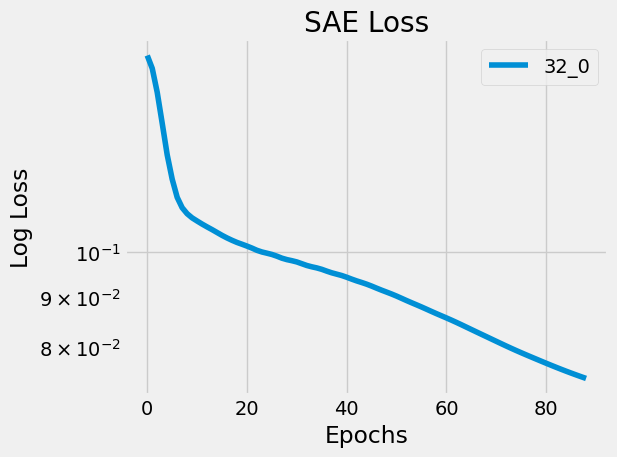

Training DAE
	(32, 1)
Epoch 0 Loss: 0.1601, Val Loss: 0.1513
Epoch 10 Loss: 0.1367, Val Loss: 0.1203
Epoch 20 Loss: 0.1175, Val Loss: 0.1201


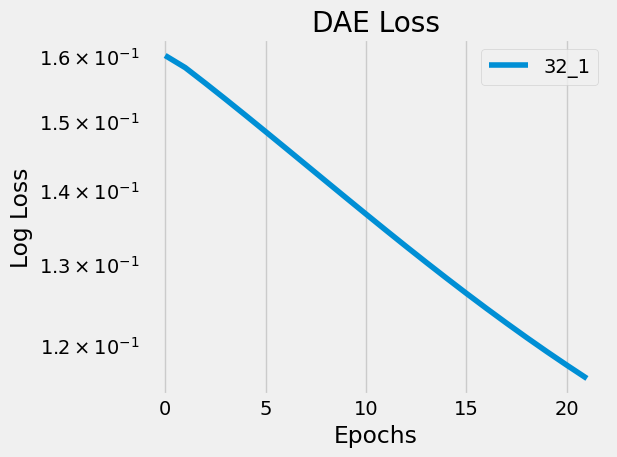

Training VAE
	(32, 4)
Epoch 0 Loss: 54.6, Val Loss: 23.68
Epoch 10 Loss: 2.295, Val Loss: 0.7559
Epoch 20 Loss: 2.014, Val Loss: 0.6318


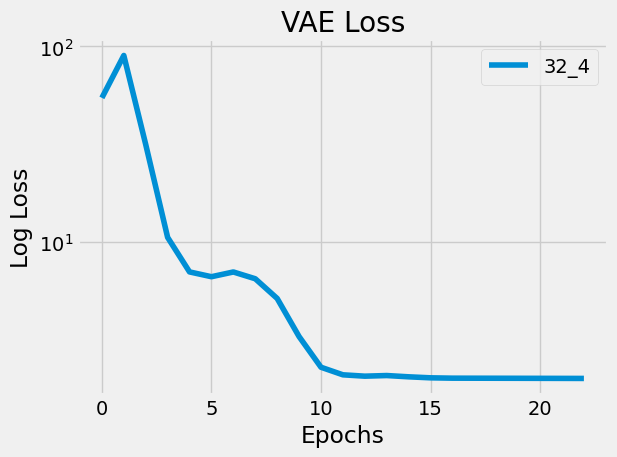

Training CAE
	(4, 2)
Epoch 0 Loss: 0.1593, Val Loss: 0.1539
Epoch 10 Loss: 0.1233, Val Loss: 0.1202
Epoch 20 Loss: 0.1186, Val Loss: 0.1171
Epoch 30 Loss: 0.1163, Val Loss: 0.1155
Epoch 40 Loss: 0.1147, Val Loss: 0.1132


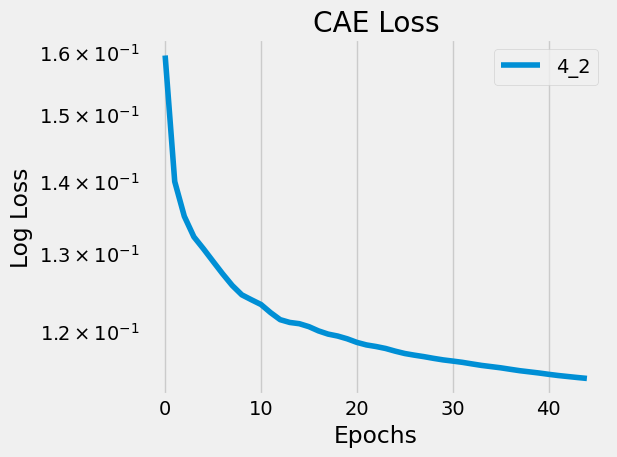

In [16]:
# Train all the AutoEncoders
dm.train_aes()

In [17]:
# Load the best model for each autoencoder
dm.get_best_aes()

('marker_IBD', 'sae', (32, 0)): 0.09122
('marker_IBD', 'dae', (32, 1)): 0.1191
('marker_IBD', 'vae', (32, 4)): 0.1499
('marker_IBD', 'cae', (4, 2)): 0.1123
{'sae': [0.09122443199157715, (32, 0)], 'dae': [0.1190948337316513, (32, 1)], 'vae': [0.14989906549453735, (32, 4)], 'cae': [0.11231838166713715, (4, 2)]}


In [18]:
# Train the classifier on the best autoencoders
dm.train_clfs()

Encoding Folds
	sae
	dae
	vae
	cae
Training Classifiers
	sae
		mlp
			(100, 3, 0.1, 300)
				Fold 0
Epoch 0 Loss: 0.6514, Val Loss: 0.6698
Epoch 10 Loss: 0.166, Val Loss: 0.4338
Epoch 0 Loss: 0.8589, Val Loss: 1.1
Epoch 10 Loss: 0.7673, Val Loss: 0.7281
Epoch 20 Loss: 0.8276, Val Loss: 0.6357
Epoch 30 Loss: 0.6765, Val Loss: 0.6211
Epoch 40 Loss: 0.6874, Val Loss: 0.619
Epoch 50 Loss: 0.6348, Val Loss: 0.6123
				Fold 1
Epoch 0 Loss: 0.7299, Val Loss: 0.6111
Epoch 10 Loss: 0.2605, Val Loss: 0.4647
Epoch 0 Loss: 0.7183, Val Loss: 0.798
Epoch 10 Loss: 0.6902, Val Loss: 0.848
				Fold 2
Epoch 0 Loss: 0.7147, Val Loss: 0.7478
Epoch 10 Loss: 0.2193, Val Loss: 0.5323
Epoch 20 Loss: 0.1777, Val Loss: 0.4926
Epoch 0 Loss: 1.179, Val Loss: 2.874
Epoch 10 Loss: 1.165, Val Loss: 1.176
Epoch 20 Loss: 1.155, Val Loss: 1.098
Epoch 30 Loss: 1.063, Val Loss: 1.091
				Fold 3
Epoch 0 Loss: 0.9798, Val Loss: 0.7546
Epoch 10 Loss: 0.3474, Val Loss: 0.667
Epoch 20 Loss: 0.283, Val Loss: 0.6284
Epoch 30 Lo

# Results

The results of evaluating the models on the test set are displayed below. AUC values for all the classifiers are printed. The AUC for a classifier trained on the original data (default) is compared with the AUC for a classifier trained on the encoded representation.

The original DeepMicro study does not train the classifiers on the default dataset, instead they directly compare their results with a previous MetAML study$^{9}$. This ablation is directly implemented in our project, were both classifiers are trained for each model.

Our results indicate that the classifiers trained on the original data consistently perform better than the classifiers trained on encoded representations. This result is different from Hypothesis 1 and the DeepMicro paper, where classifying on the encoded representations performs better.

In [19]:
with open('clf_dict', 'rb') as fo:
    clf_dict = pickle.load(fo)

agg_metrics = {}
best_auc = {}
print('Default vs. Encoded AUCs')
for key, value in clf_dict.items():
    if key[0] == file_name:
        if key[1] not in best_auc.keys():
            best_auc[key[1]] = [[-1, ()], [-1, ()]]

        agg_metrics[key] = [[0, 0, 0], [0, 0, 0]]
        for k, fold in enumerate(value):
            for i, model in enumerate(fold):
                for j, metric in enumerate(model[1]):
                    agg_metrics[key][i][j] += metric/NUM_FOLDS

        if agg_metrics[key][0][2] > best_auc[key[1]][0][0]:
            best_auc[key[1]][0][0] = agg_metrics[key][0][2]
            best_auc[key[1]][0][1] = key

        if agg_metrics[key][1][2] > best_auc[key[1]][1][0]:
            best_auc[key[1]][1][0] = agg_metrics[key][1][2]
            best_auc[key[1]][1][1] = key
        
        print(key)
        print(f'\t{agg_metrics[key][0][2]:.4} vs. {agg_metrics[key][1][2]:.4}')

Default vs. Encoded AUCs
('marker_IBD', 'sae', (32, 0), 'mlp', (100, 3, 0.1, 300))
	0.8612 vs. 0.4894
('marker_IBD', 'sae', (32, 0), 'svm', (0.5, 0.0078125))
	0.5 vs. 0.8475
('marker_IBD', 'sae', (32, 0), 'rf', (100, 'gini', 1, 'sqrt'))
	0.8464 vs. 0.8773
('marker_IBD', 'dae', (32, 1), 'mlp', (100, 3, 0.1, 300))
	0.8706 vs. 0.6471
('marker_IBD', 'dae', (32, 1), 'svm', (0.5, 0.0078125))
	0.5 vs. 0.7176
('marker_IBD', 'dae', (32, 1), 'rf', (100, 'gini', 1, 'sqrt'))
	0.8842 vs. 0.7464
('marker_IBD', 'vae', (32, 4), 'mlp', (100, 3, 0.1, 300))
	0.8894 vs. 0.4859
('marker_IBD', 'vae', (32, 4), 'svm', (0.5, 0.0078125))
	0.5 vs. 0.4805
('marker_IBD', 'vae', (32, 4), 'rf', (100, 'gini', 1, 'sqrt'))
	0.858 vs. 0.5617
('marker_IBD', 'cae', (4, 2), 'mlp', (100, 3, 0.1, 300))
	0.8871 vs. 0.5459
('marker_IBD', 'cae', (4, 2), 'svm', (0.5, 0.0078125))
	0.5 vs. 0.8261
('marker_IBD', 'cae', (4, 2), 'rf', (100, 'gini', 1, 'sqrt'))
	0.8555 vs. 0.7102


### Best AUCs

For each AutoEncoder type, the best classifer for both the default data and the encoded representation is printed below.
Since this illustration is designed to train fast, some of the models have a poor evaluation score. This is an expected result. The complete set of results for all datasets is uploaded to the GitHub repository.

In [20]:
for key, value in best_auc.items():
    print(key)
    best_def_key = value[0][1]
    best_en_key = value[1][1]
    print(f'\tBest Default: {best_def_key}')
    print(f'\t\t Default ROC AUC: {agg_metrics[best_def_key][0][2]:.4}')
    print(f'\t\t Encoded ROC AUC: {agg_metrics[best_def_key][1][2]:.4}')
    print(f'\tBest Encoded: {best_en_key}')
    print(f'\t\t Default ROC AUC: {agg_metrics[best_en_key][0][2]:.4}')
    print(f'\t\t Encoded ROC AUC: {agg_metrics[best_en_key][1][2]:.4}')

sae
	Best Default: ('marker_IBD', 'sae', (32, 0), 'mlp', (100, 3, 0.1, 300))
		 Default ROC AUC: 0.8612
		 Encoded ROC AUC: 0.4894
	Best Encoded: ('marker_IBD', 'sae', (32, 0), 'rf', (100, 'gini', 1, 'sqrt'))
		 Default ROC AUC: 0.8464
		 Encoded ROC AUC: 0.8773
dae
	Best Default: ('marker_IBD', 'dae', (32, 1), 'rf', (100, 'gini', 1, 'sqrt'))
		 Default ROC AUC: 0.8842
		 Encoded ROC AUC: 0.7464
	Best Encoded: ('marker_IBD', 'dae', (32, 1), 'rf', (100, 'gini', 1, 'sqrt'))
		 Default ROC AUC: 0.8842
		 Encoded ROC AUC: 0.7464
vae
	Best Default: ('marker_IBD', 'vae', (32, 4), 'mlp', (100, 3, 0.1, 300))
		 Default ROC AUC: 0.8894
		 Encoded ROC AUC: 0.4859
	Best Encoded: ('marker_IBD', 'vae', (32, 4), 'rf', (100, 'gini', 1, 'sqrt'))
		 Default ROC AUC: 0.858
		 Encoded ROC AUC: 0.5617
cae
	Best Default: ('marker_IBD', 'cae', (4, 2), 'mlp', (100, 3, 0.1, 300))
		 Default ROC AUC: 0.8871
		 Encoded ROC AUC: 0.5459
	Best Encoded: ('marker_IBD', 'cae', (4, 2), 'svm', (0.5, 0.0078125))
		 Defa

# Discussion

Our results are in line with Hypothesis 2; the classifiers train faster on the learned representation. This is because the dimension of the learned representation is much smaller than the original data. This result was verified empirically during the model training process. However it should be noted that the total time taken for training both the encoder and the classifier is much higher than just training the classifier. This means that for a new set of data, finding the learned representation would be impractical, compared to training the classifiers directly.

Hypothesis 1 states that the accuracy of classifers trained on the learned representation is expected to be higher than those trained directly on the datasets. The results of our project are the opposite of the hypothesis and the findings of the original DeepMicro study. The following points discuss possible explanations for these results.

- Error in the training process of the autoencoders: The training loss graphs of the autoencoders have the expected shape (for Log Loss vs. Epochs). Moreover most models have a validation loss (MSE) in the range of 0.05 and 0.1. These results are in line with those of the DeepMirco study.
- PyTorch vs. Keras/TensorFlow: The DeepMicro study makes use of machine learning models in Keras, whereas our models are implemented in PyTorch. Hyperparameters related to model training (e.g. learning rate and early stopping) need to be customized for each dataset. These tasks are handled by Keras automatically. In our project many of the autoencoders might be trained with a poor choice of training parameters and thus underperform.
- Reliance on MetAML study: The DeepMicro study builds on top of the MetAML study, instead of training their own classifiers on the original dataset. It is probable that the models built by DeepMicro are superior to those built by MetAML. Several factor affect the performance of machine learning models and it is expected that not all these factors can be controlled in between the two studies.

FIGURE 1. Abundance Colorectal results from our project
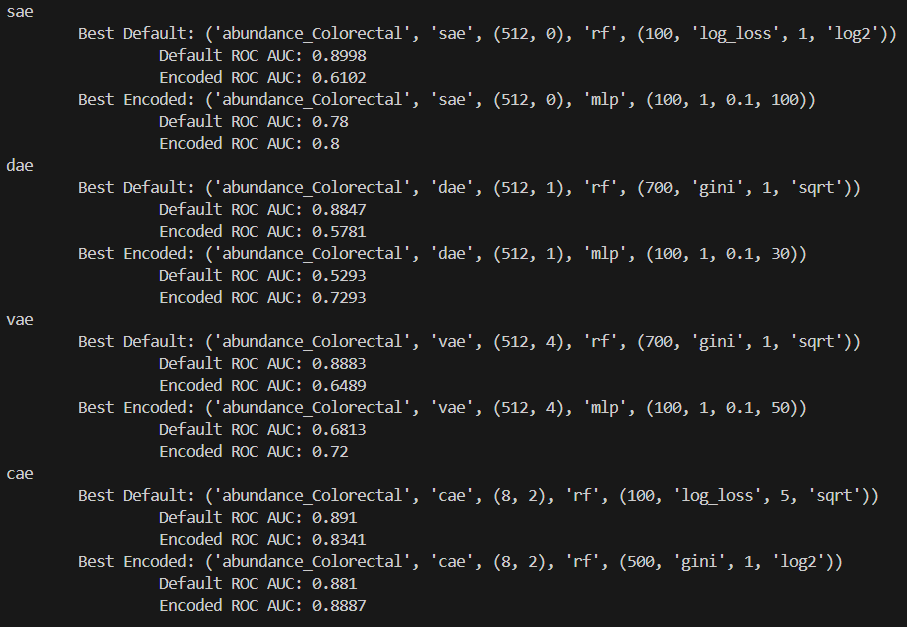

FIGURE 2. Abundance Colorectal results from DeepMirco Study
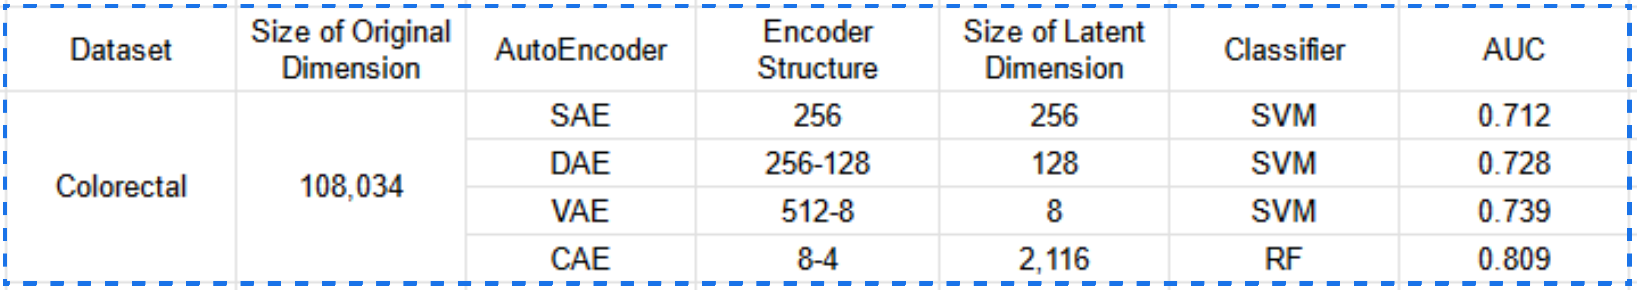

Figure 1. shows the results from training the Abundance Colorectal dataset on our project. The best classifier models trained on the encoded representations result in the following AUCs:
- SAE: 0.800
- DAE: 0.730
- VAE: 0.720
- CAE: 0.889

Figure 2. are the results from the DeepMicro study. The classifiers from our study performed slightly better on SAE, CAE and similarly on DAE, VAE.

More importantly, the classifiers trained directly on the data performed significantly better for all the AutoEncoders.
- SAE: 0.900
- DAE: 0.885
- VAE: 0.888
- CAE: 0.891

These results indicate that the models in our project are trained correctly. Moreover, there must be significant differences in the models developed by DeepMicro and AML studies to results in the discrepancies, which were discussed in the introduction.

### Ease of Reproduction
Implementing all the neural network models in PyTorch was a straightforward task. The implementation of SVM and RF in SciKit Learn was even simpler. The DeepMirco study was referenced throughout the model building process.

The difficulty arose in deciding the optimal set of training specific hyperparamters, e.g. maximum epochs, learning rate, patience and rho (early stopping). Tuning these hyperparameters manually is a difficult task and needs to be automated. Additionally, we need a metric to determine the best hyperparameters.

### Future Plans and Suggestions
Future plans for this project include
- Add new datasets obtained from the phylaGAN$^5$ and MV-CVIB$^6$ studies.
- Increase the size of datasets using bootstrap methods.
- Increase the size of datasets using generative models.
- Develop techniques to employ the optimal training specific hyperparamters for every combination of dataset, model type, etc.

A suggestion for the DeepMicro authors is to implement the ablation of training the classifiers directly on the datasets along with the encoded representation. This will ensure fairness in a comparison between the two methods.


# References
1. Cho, I. & Blaser, M. J. The human microbiome: at the interface of health and disease. Nature Reviews Genetics 13, 260 (2012).
2. Eloe-Fadrosh, E. A. & Rasko, D. A. The human microbiome: from symbiosis to pathogenesis. Annual review of medicine 64, 145-163 (2013).
3. Hamady, M. & Knight, R. Microbial community profiling for human microbiome projects: tools, techniques, and challenges. Genome research 19, 1141-1152 (2009).
4. Scholz, M. et al. Strain-level microbial epidemiology and population genomics from shotgun metagenomics. Nature methods 13, 435 (2016).
5. Divya Sharma, Wendy Lou, Wei Xu, phylaGAN: Data augmentation through conditional GANs and autoencoders for improving disease prediction accuracy using microbiome data, Bioinformatics, 2024;, btae161, https://doi.org/10.1093/bioinformatics/btae161
6. Cui Z, Wu Y, Zhang Q-H, Wang S-G, He Y and Huang D-S (2023) MV-CVIB: a microbiome-based multi-view convolutional variational information bottleneck for predicting metastatic colorectal cancer. Front. Microbiol. 14:1238199. doi: 10.3389/fmicb.2023.1238199
7. U. Gülfem Elgün Çiftcioğlu, O. Ufuk Nalbanoglu, DeepGum: Deep feature transfer for gut microbiome analysis using bottleneck models, Biomedical Signal Processing and Control, Volume 91, 2024, 105984, ISSN 1746-8094, https://doi.org/10.1016/j.bspc.2024.105984.
8. Oh, Min, and Liqing Zhang. "DeepMicro: deep representation learning for disease prediction based on microbiome data." *Scientific Reports* 10.1 (2020): 1-9. https://doi.org/10.1038/s41598-020-63159-5.
9. Pasolli, E., Truong, D. T., Malik, F., Waldron, L. & Segata, N. Machine learning meta-analysis of large metagenomic datasets: tools and biological insights. PLoS computational biology 12, e1004977 (2016).
10. https://github.com/minoh0201/DeepMicro